## Intro

In my previous blog post, I discussed how to use Cython to get a more than hundredfold speed improvement on training an adaptive equaliser for optical communications experiments and simulations. The downside to that gain was that the optimised Cython-code was quite unwieldy and contained a lot of boilerplate. Something I was trying to avoid by using Python. Thus making the code much easier to use and adjust for our students. 

In this blog post I will investigate several other methods of speeding up numerical Python code and benchmark them against each other. The benchmarks can be found at [this](https://gitlab.com/Jochen/benchmarknotebooks) gitlab repository.

The methods we are looking at are:

**[Numpy](https://numpy.org/)**
The Numpy module provides an array class together with a lot of numerical functions. It is at the core of almost every numerical and scientific package for Python. Here it is going to be our baseline performance.

**[Cython](https://cython.org/)** 
Cython is a superset of the Python language which can be compiled to C-code. Ideally, if one eliminates most accesses to Python objects it can achieve almost the same speed as C. However, the more you optimize Cython the more it will look like C and less like Python. We showed in our previous post that it achieves an almost 200-fold performance increase on my system over the numpy version.

**[Numba](http://numba.pydata.org/)**
Numba is a JIT compiler for a subset of Python and numpy which allows you to compile your code with very minimal changes. In theory it can achieve performance on par with Fortran or C. It can automatically optimize for SIMD instructions and adapts to your system. While numba also allows you to compile for GPUs I have not included that here.

**[Pythran](https://github.com/serge-sans-paille/pythran)** 
Pythran is a bit the new kid on the block. It's an ahead of time compiler for numerical and scientific python that can take advantage of SIMD instructions and OpenMP directives to speed up your code. It allows compiling to C++ and doesn't need a python interpreter so can be used for prototyping code for e.g. embedded devices. Note that recently it has become possible to use Pythran to compile numpy code within Cython. 

**[Julia](https://julialang.org/)**
Is not a way of speeding up Python code, but instead a different programming language. It was developed with the aim of being a replacement for matlab and has seen a lot of attention lately as it is a dynamic language with familiar syntax for people who know matlab or python with very high performance. I've included it here to see how it compares to the other options.

### Note on optimizations

I have not spend the same amount of time as I did for optimizing the cython code on the other methods. I believe that it is generally still a fair comparison, because the all other methods promote that they essentially achieve the speed-gains with very little additional effort. However, if you see that I missed a significant optimisation please create a pull-request to the repostory and I will update the code. 

## Benchmark

We are using the training of an adaptive equaliser as our benchmark program. This is a very common function for modern optical communications systems and we generally want it to be as fast as possible when processing our experimental data. You can find a more detailed discussion on my previous blogpost. Importantly we will be using QAMpy a processing and simulation chain for optical communications, you can find it on github [here](https://github.com/ChalmersPhotonicsLab/QAMpy)

### Initialise packages

Let's first import all relevant packages 

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from qampy import signals, impairments, equalisation
import pythran
import cython 
import numba
import timeit
from timeit import default_timer as timer
import julia
%load_ext julia.magic
%load_ext pythran.magic
%load_ext cython

Initializing Julia interpreter. This may take some time...


## Numpy

To establish a performance baseline we are not going to implement the algorithm in pure python, but instead go directly to numpy. Please look at the previous [post](https://jochen.gitlab.io/blog/articles/DSP_with_Python1/) for some description of the functions. 

In [3]:
def apply_filter_npy(E,wx):
    Xest = 0 +0j
    for i in range(E.shape[0]):
        Xest += np.dot(E[i], wx[i].conj().T)
    return Xest

def cma_numpy(E, wxy, mu, R, os):
    pols, L = E.shape
    assert wxy.shape[0] == pols
    assert wxy.shape[1] == pols
    ntaps = wxy.shape[-1]
    N = (L//os//ntaps-1)*ntaps
    err = np.zeros((pols, L), dtype=np.complex128)
    for k in range(pols):
        for i in range(N):
            X = E[:, i*os:i*os+ntaps]
            Xest = apply_filter_npy(X, wxy[k])
            err[k,i] = (R-abs(Xest)**2)*Xest
            wxy[k] += mu*np.conj(err[k,i])*X
    return err, wxy 

### Simulation 

We are going to set up the simulation enviroment using QAMpy first. As previously we are simply simulating a channel with additive White Gaussion Noise (AWGN) and a root-raised cosine pulse-shaping filter. So our adaptive equaliser is only performing matched filtering. However that should not have any influence on the simulation performance.

In [4]:
s = signals.SignalQAMGrayCoded(4, 10**5, nmodes=2, fb=10e9)
s2 = s.resample(s.fb*2, beta=0.01)
s3 =  impairments.change_snr(s2, 10)
wxy0 = np.zeros((2,2,21), dtype=np.complex128)
wxy0[0][0][21//2] =1
wxy0[1][1][21//2] = 1

Let have a look at the constellation diagram.

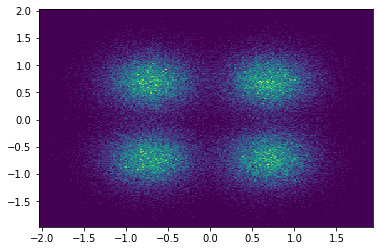

In [5]:
plt.figure()
plt.hist2d(s3[0,::2].real, s3[0,::2].imag, bins=200)
plt.show()

What we see here is a combination of the SNR and the ISI from the lack of matched filtering for the pulse-shaping. We can also calculate the BER. 

In [6]:
s3[:,::2].copy().cal_ber()

array([0.012915, 0.01282 ])

#### Numpy benchmark

Here is the timing of the numpy function, which be our reference

In [7]:
wxyin = wxy0.copy() # we are copying the initial taps so we don't overwrite them
err, wxy = cma_numpy(s3, wxyin, 1e-3, 1, s3.os) 
t_numpy = timeit.timeit("cma_numpy(s3, wxyin, 1e-3, 1, s3.os)", number=3, globals=globals())/3
print("Numpy time = {:.3f}".format(t_numpy))
out = equalisation.apply_filter(s3, wxy)
print("BER = {}".format(out.cal_ber()))

Numpy time = 5.805
BER = [0.00139514 0.00139514]


As in my previous post, numpy took about 5.5 s for processing the 100,000 symbols, on my Ryzen 3600 system. We can also see that the adaptive filter improved performance by a factor of 10. 
Generally 100,000 symbols is on the lower end of what we measure and 5 s is quite a wait so we really want to go faster than this. 

## Cython

We are only going to use the fully optimized version of the Cython function here.

In [7]:
%%cython -c=-Ofast -c=-ffast-math -c=-mfpmath=sse -c=-funroll-loops -c=-march=native
import numpy as np
cimport numpy as cnp
import cython

cdef extern from "complex.h" nogil:
    double complex conj(double complex)

@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
cdef double complex apply_filter_pyx(double complex[:,:] E, double complex[:,:] wx) nogil:
    cdef int j, k, M, N
    cdef double complex Xest = 0
    M = E.shape[0]
    N = E.shape[1]
    for i in range(M):
        for j in range(N):
            Xest += E[i,j] * conj(wx[i,j])
    return Xest


@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
def cma_pyx1(double complex[:,:] E, double complex[:,:,:] wxy, double mu, double R, int os):
    cdef int i,j,l,k,pols, N, ntaps
    cdef double complex[:,:] err
    cdef double complex[:,:] X
    cdef double complex Xest
    ntaps = wxy.shape[2]
    pols = E.shape[0]
    L = E.shape[1]
    N = (L//os//ntaps-1)*ntaps
    err = np.zeros((pols, L), dtype=np.complex128)
    for k in range(pols):
        for i in range(N):
            X = E[:, i*os:i*os+ntaps]
            Xest = apply_filter_pyx(X, wxy[k])
            err[k,i] = (R-abs(Xest)**2)*Xest
            for j in range(pols):
                for l in range(ntaps):
                    wxy[k, j, l] = wxy[k, j, l] + mu * conj(err[k, i])*X[j,l]
    return err,wxy



#### Cython benchmark

In [8]:
wxyin = wxy0.copy()
err, wxy = cma_pyx1(s3, wxyin, 1e-3, 1, s3.os)
t_cython = timeit.timeit("cma_pyx1(s3, wxyin, 1e-3, 1, s3.os)", number=10, globals=globals())/10
print("Cython initial time = {:.3f}".format(t_cython))
print("Cython vs numpy speed up = {:.1f}".format(t_numpy/t_cython))
out = equalisation.apply_filter(s3, wxy)
print("BER = {}".format(out.cal_ber()))

Cython initial time = 0.021
Cython vs numpy speed up = 264.3
BER = [0.00414541 0.00139514]


So as before about a factor 260 speed-up on my Ryzen 3600 system. 

## Numba

Ok so let's see how Numba compares. Generally, to compile functions using numba you should use the jit decorator and if you want to make sure you receive the full speed up you need to pass `nopython=True` which means to not compile a (slow) python version (this can lead to compile failures though). Here is our numpy functions just with added numba decorators.

In [9]:
@numba.jit(nopython=True)
def apply_filter_nb1(E, wx):
    Xest = 0 +0j
    #Xest = np.sum(E*np.conj(wx))
    for i in range(E.shape[0]):
        Xest += np.dot(np.copy(E[i]), wx[i].conj().T)
    return Xest

@numba.jit(nopython=True)
def cma_nb1(E, wxy, mu, R, os):
    pols, L = E.shape
    assert wxy.shape[0] == pols
    assert wxy.shape[1] == pols
    ntaps = wxy.shape[-1]
    N = (L//os//ntaps-1)*ntaps
    err = np.zeros((pols, L), dtype=np.complex128)
    for k in range(pols):
        for i in range(N):
            X = E[:, i*os:i*os+ntaps]
            Xest = apply_filter_nb1(X, wxy[k])
            err[k,i] = (R-abs(Xest)**2)*Xest
            wxy[k] += mu*np.conj(err[k,i])*X
    return err, wxy 

Because numba is a JIT we need to prerun the function once so that we do not measure the compile time in our benchmark. Note that if you can, pre-compile your code.

#### Numba benchmark 

In [10]:
wxin = wxy0.copy()
err, wxy = cma_nb1(s3, wxyin, 1e-3, 1, s3.os) # we don't want to measure the compile time
wxin = wxy0.copy()
t_numba1 = timeit.timeit("cma_nb1(s3, wxyin, 1e-3, 1, s3.os)", number=10, globals=globals())/10
print("Time numba = {:.4f}".format(t_numba1))
print("Numba vs numpy speed-up = {:.1f}".format(t_numpy/t_numba1))
      
out = equalisation.apply_filter(s3, wxy)
print("BER= {}".format(out.cal_ber()))

Time numba = 0.1138
Numba vs numpy speed-up = 48.2
BER= [0.02163716 0.00143514]


That took 0.11 s on my machine, not quite as fast as cython, but still more than 48 times faster than the numpy version. So quite an impressive speed-up for just adding some decorators. 

You might wonder about the `np.copy(E[i])` in the apply filter function. This is because numba can perform better on contiguous arrays (and recent numba versions will print a warning). The speed-up from the copy is however quite modest (the time changes from about 0.125 s to 0.114 s). I have included it nonetheless.

Still it's a factor of 5 slower than the cython version so naturally we can ask if we can we do better?

### Optimise numba 

Numba sometimes has issues with vectorised code. Si if we write the code out it looks like this. We also use the fastmath keyword which is equivalent to passing -ffast-math to the compiler.

In [11]:
@numba.jit(nopython=True, fastmath=True)
def apply_filter_nb2(E, wx):
    Xest = 0 +0j
    for i in range(E.shape[0]):
        for j in range(E.shape[1]):
            Xest += E[i,j] * np.conj(wx[i,j])
    return Xest

@numba.jit(nopython=True, fastmath=True)
def cma_nb2(E, wxy, mu, R, os):
    pols, L = E.shape
    ntaps = wxy.shape[-1]
    N = (L//os//ntaps-1)*ntaps
    err = np.zeros((pols, L), dtype=np.complex128)
    for k in range(pols):
        for i in range(N):
            X = E[:, i*os:i*os+ntaps]
            Xest = apply_filter_nb2(X, wxy[k])
            err[k,i] = (R-abs(Xest)**2)*Xest
            #wxy[k] += mu*np.conj(err[k,i])*X
            for j in range(pols):
                for l in range(ntaps):
                    wxy[k,j,l] += mu*np.conj(err[k,i])*X[j,l]
    return err, wxy 

#### Optimised numba benchmark

In [12]:
wxin = wxy0.copy()
err, wxy = cma_nb2(s3, wxyin, 1e-3, 1, s3.os) # we don't want to measure the compile time
wxin = wxy0.copy()
t_numba2 = timeit.timeit("cma_nb2(s3, wxyin, 1e-3, 1, s3.os)", number=10, globals=globals())/10
print("Time numba = {:.4f}".format(t_numba2))
print("Numba vs numpy speed-up = {:.1f}".format(t_numpy/t_numba2))    
out = equalisation.apply_filter(s3, wxy)
print("BER= {}".format(out.cal_ber()))

Time numba = 0.0340
Numba vs numpy speed-up = 161.3
BER= [0.0849735  0.00143014]


Oh wow, a speed-up of ~160 compared to numpy, we are almost as fast as cython while avoiding the boilercode that is needed with cython. However, can we some additional speed with parallisation?


### Parellise 

As I mentioned for the cython code the loop over the polarisations can be trivally parallised. With numba this is actually quite straight-forward using the parallel argument. Often it is smart enough to figure things out for itself, but sometimes you need to explicitely parallise a loop using the prange function. Also note that we are passing `nogil=True` to the decorator for `apply_filter` to enable it to be run in parallel.

In [13]:
@numba.jit(nopython=True, fastmath=True, nogil=True)
def apply_filter_nb3(E, wx):
    Xest = 0 +0j
    for i in range(E.shape[0]):
        for j in range(E.shape[1]):
            Xest += E[i,j] * np.conj(wx[i,j])
    return Xest

@numba.jit(nopython=True, fastmath=True, parallel=True)
def cma_nb3(E, wxy, mu, R, os):
    pols, L = E.shape
    ntaps = wxy.shape[-1]
    N = (L//os//ntaps-1)*ntaps
    err = np.zeros((pols, L), dtype=np.complex128)
    for k in numba.prange(pols):
        for i in range(N):
            X = E[:, i*os:i*os+ntaps]
            Xest = apply_filter_nb2(X, wxy[k])
            err[k,i] = (R-abs(Xest)**2)*Xest
            #wxy[k] += mu*np.conj(err[k,i])*X
            for j in range(pols):
                for l in range(ntaps):
                    wxy[k,j,l] += mu*np.conj(err[k,i])*X[j,l]
    return err, wxy 

#### Parallel numba benchmark

In [15]:
wxin = wxy0.copy()
err, wxy = cma_nb3(s3, wxyin, 1e-3, 1, s3.os) # we don't want to measure the compile time
t_numba3 = timeit.timeit("cma_nb3(s3, wxyin, 1e-3, 1, s3.os)", number=10, globals=globals())/10
print("Time numba (parallel) = {:.4f}".format(t_numba3))
print("Numba vs numpy speed-up = {:.1f}".format(t_numpy/t_numba3))    
out = equalisation.apply_filter(s3, wxy)
print("BER= {}".format(out.cal_ber()))

Time numba (parallel) = 0.0248
Numba vs numpy speed-up = 221.0
BER= [0.12965797 0.00150015]


~200 times faster than numpy, now we as fast as the cython version with the code remaining relatively simple.

## Pythran

Pythran is a ahead of time compiler of a subset of numpy and Python. It works by supplying a pythran export command which defines the interface of your function. The good thing is that pythran commands are comments so the code works as normal python code if you do not compile it, which can be great for debugging.

**Note** You can and should supply your compiler flags to numba. You can add them to your commandline or notebook magic commands, but also add default parameters to a `.pythranrc` file in your home directory. The examples here were compiled with gcc and `cflags: -O3 -ffast-math -mfpmath=sse -funroll-loops -fopenmp -march=native -std=c++14 -fno-math-errno -w -fvisibility=hidden -fno-wrapv -DUSE_XSIMD -DNDEBUG`. 

Also unlike cython modules you do not need to compile pythran modules with the same compiler that python was compiled with. In fact the recommend way for compiling under windows is to use LLVM.

In [16]:
%%pythran
import numpy as np

def apply_filter_pt1(E, wx):
    Xest = np.sum(E*np.conj(wx))
    return Xest

#pythran export cma_pt1(complex128[][], complex128[][][], float64, float64, int)
def cma_pt1(E, wxy, mu, R, os):
    pols, L = E.shape
    assert wxy.shape[0] == pols
    assert wxy.shape[1] == pols
    assert E.shape[1] <= wxy.shape[-1]
    ntaps = wxy.shape[-1]
    N = (L//os//ntaps-1)*ntaps
    err = np.zeros((pols, L), dtype=np.complex128)
    for k in range(pols):
        for i in range(N):
            X = E[:, i*os:i*os+ntaps]
            Xest = apply_filter_pt1(X, wxy[k])
            err[k,i] = (R-abs(Xest)**2)*Xest
            wxy[k] += mu*np.conj(err[k,i])*X
    return err, wxy 

#### Pythran benchmark

Let's see how this code performs.

In [17]:
wxin = wxy0.copy()
t_pythran1 = timeit.timeit("cma_pt1(np.copy(s3), wxyin, 1e-3, 1., s3.os)", number=10, globals=globals())/10
print("Time pythran = {:.4f}".format(t_pythran1))
print("Pythran vs numpy speed-up = {:.1f}".format(t_numpy/t_pythran1))    
out = equalisation.apply_filter(s3, wxy)
print("BER= {}".format(out.cal_ber()))

Time pythran = 0.0386
Pythran vs numpy speed-up = 142.1
BER= [0.04440944 0.00156516]


That's a >140 speed-up straight out of the box, by just adding some comments, even faster than numba!

### Optimise Pythran

Let's try the same optimisation we did for numba and see what it yields.

In [18]:
%%pythran

import numpy as np

def apply_filter_pt2(E, wx):
    Xest = 0+0j
    for i in range(E.shape[0]):
        for j in range(E.shape[1]):
            Xest += E[i,j] * wx[i,j].conj()
    return Xest

#pythran export cma_pt2(complex128[][], complex128[][][], float64, float64, int)
def cma_pt2(E, wxy, mu, R, os):
    pols, L = E.shape
    assert wxy.shape[0] == pols
    assert wxy.shape[1] == pols
    assert E.shape[1] <= wxy.shape[-1]
    ntaps = wxy.shape[-1]
    N = (L//os//ntaps-1)*ntaps
    err = np.zeros((pols, L), dtype=np.complex128)
    for k in range(pols):
        for i in range(N):
            X = E[:, i*os:i*os+ntaps]
            Xest = apply_filter_pt2(X, wxy[k])
            err[k,i] = (R-abs(Xest)**2)*Xest
            for j in range(pols):
                for l in range(ntaps):
                    wxy[k, j, l] += mu*np.conj(err[k,i])*X[j,l]
    return err, wxy 

#### Optimised Pythran Benchmark

Does this improve performance?

In [20]:
wxin = wxy0.copy()
t_pythran2 = timeit.timeit("cma_pt2(np.copy(s3), wxyin, 1e-3, 1., s3.os)", number=10, globals=globals())/10
print("Time pythran = {:.4f}".format(t_pythran2))
print("Pythran vs numpy speed-up = {:.1f}".format(t_numpy/t_pythran2))    
out = equalisation.apply_filter(s3, wxy)
print("BER= {}".format(out.cal_ber()))

Time pythran = 0.0170
Pythran vs numpy speed-up = 322.1
BER= [0.01112111 0.00159016]


That's quite a bit faster than numba even without parallising the loop (in fact that causes a slight slow-down) and arguably the code is still reasonably simple. 

**Note**: The Pythran benchmarks were run using Pythran 0.9.5, in more recent Pythran versions there is a performance regression which significantly slows down the above code ([issue](https://github.com/serge-sans-paille/pythran/issues/1668)). This is arguably one of the disadvantages of using packages under strong development. 

## Julia

As the last thing let us check Julia, it's not strightly in the same category as Pythran and Numba, because we are rewriting in a different language, but considering that it's the hot thing at the moment I wanted to see how fast it is. Note that I am not very familiar with Julia, so I might have missed some important optimization. 

Because Julia indexing starts at 1 compared to python which starts at 0 we need to be careful when converting the code, it's easy to make mistakes (at least I always do make some on my first go). 


We are using the [pyjulia](https://github.com/JuliaPy/pyjulia) package here to access Julia from Python, which is quite nice and easy.

In [21]:
%%julia

function apply_filter_jl(E, wx)
    Xest = sum(E.*conj(wx))
    return Xest
end

function cma_jl(E, wxy, mu, R, os)
    pols, L = size(E)
    ntaps = size(wxy,ndims(wxy)[end])
    N = Int(floor((L /os /ntaps -1)*ntaps))
    err = zeros(Complex, pols, L)
    for k=1:pols
        for i=1:N
            X = E[:, i*os-1:i*os+ntaps-2]
            Xest = apply_filter_jl(X, wxy[k,:,:])
            err[k,i] = (R-abs(Xest)^2)*Xest
            wxy[k,:,:] += mu*conj(err[k,i])*X
        end
    end
    return err, wxy
end
    


<PyCall.jlwrap cma_jl>

#### Julia Benchmark

Below is the benchmark code. Note that we use the `@timed` macro in Julia for the timing to remove the possible overhead in the measurement (although there might still be remaining overhead affecting the results). 

In [ ]:
wxyin = np.asfortranarray(wxy0)
%julia wxyin = $wxyin
%julia s4 = $s3
%julia cma_jl(s4, wxyin, 1e-3, 1., 2) # we are running once to prep the compiler
%julia wxyin = $wxyin
%julia  val, t, bytes, gctime, memallocs = @timed cma_jl(s4, wxyin, 1e-3, 1., 2)
t_julia1=%julia t
err,wxy = %julia val
t_julia2 = end-start
print("Time Julia = {:.4f}".format(t_julia1))
print("Julia vs numpy speed-up = {:.1f}".format(t_numpy/t_julia1))
wxx = np.ascontiguousarray(wxy)
out = equalisation.apply_filter(s3, wxx)
print("BER= {}".format(out.cal_ber()))


So that is a speedup of a factor 18 compared to numpy. Which is significant, but considering that Julia is often advertised as C-speed with Python usability I was quite surprised. This is still less than half the speedup we got from both numba and pythran just by adding the comments and decorators. 

### Optimised Julia

I tried to improve the performance by similar to what I did for numba and pythran, i.e. rewriting the vectorized functions into explicit loops. There are also the `@inbounds`, `@fastmath` and `@simd` decorators that instruct Julia to omit bound-checks, and use fastmath and simd instructions. 

In [22]:
%%julia

function apply_filter_jl4(E, wx)
    Xest = 0+0im
    @inbounds for i=1:size(E,1)
        @inbounds for j=1:size(E,2)
            Xest += E[i,j]*conj(wx[i,j])
        end
    end
    return Xest
end

function cma_jl4(E, wxy, mu, R, os)
    pols, L = size(E)
    ntaps = size(wxy,ndims(wxy)[end])
    N = Int(floor((L /os /ntaps -1)*ntaps))
    err = zeros(Complex, pols, L)
    @inbounds for k=1:pols
        @inbounds @fastmath @simd for i=1:N
            X = E[:, i*os-1:i*os+ntaps-2]
            Xest = apply_filter_jl4(X, wxy[k,:,:])
            err[k,i] = (R-abs(Xest)^2)*Xest
            wxy[k,:,:] += mu*conj(err[k,i])*X
        end  
    end
    return err, wxy
end
    


<PyCall.jlwrap cma_jl4>

#### Optimised Julia Benchmark

In [23]:
wxyin = np.asfortranarray(wxy0)
%julia wxyin = $wxyin
%julia s4 = $s3
%julia cma_jl4(s4, wxyin, 1e-3, 1., 2)
%julia wxyin = $wxyin
start = timer()
%julia  val, t, bytes, gctime, memallocs = @timed cma_jl4(s4, wxyin, 1e-3, 1., 2)
end=timer()
t_julia2=%julia t
err,wxy = %julia val
#t_julia1 = end-start
print("Time Julia = {:.4f}".format(t_julia2))
print("Julia vs numpy speed-up = {:.1f}".format(t_numpy/t_julia2))
wxx = np.ascontiguousarray(wxy)
out = equalisation.apply_filter(s3, wxx)
print("BER= {}".format(out.cal_ber()))


Time Julia = 0.2443
Julia vs numpy speed-up = 22.4
BER= [0.00117512 0.00138514]


Only a very small improvement to the previous results. I tried adding the `@simd` and `@fastmath` to some of the other loops, but it typically only resulted in slowdowns. At that point I gave up. It might very well be possible that I missed an important way to optimize the code, if that is the case please create a pull request. 

## Conclusions


In my previous post I talked about how we can significantly speed up python code using cython. However, to get the ultimate performance, we need to add significant amounts of boilerplate and the resulting code looks hardly like python any longer. I therefore tested two other popular packages for speeding up numerical python code. Numba and Pythran both achieve impressive speed-ups without much more than adding some comments and decorators. In particular Pythran could get about 140 times improvement over numpy by only adding the pythran export comments, which have the advantage that the code remains valid python when one does not want to compile the code. 

If we further rewrite the code in particular using explicit loops, results in pythran and numba achieving the same performance as cython (pythran even outperforming it by some margin). In the case of pythran this does take away the advantage of being able to run the code without compilation, as it becomes very slow due to the explicit loops. 

Finally, I wanted to also test Julia, which is the current hot language for numerical computing. While Julia was significantly faster than numpy, it was surprised that it was still quite a bit slower than both pythran and numba, even when we only add the comments/decorators. 

Because of what we found here, we have decided to use pythran for qampy from now on, because it makes the transition from python much easier compared to cython which required a lot of tweaking to get the best performance.



## Update 18/01/2021

The benchmarks above have changed somewhat in the last months. In particular Pythran has improved quite a bit, the issue mentioned above has been fixed and in fact the "unoptimized" code now runs faster than the optimized one. I'm certainly impressed with the progress that pythran has made over the last year.

## Update 19/01/2021

User DNF2 on HN pointed out some issues with my Julia code (I am quite a novice it). In particular he pointed out I should use a `Complex{Float64}` type instead of the abstract `Complex` type and also that I was not considering that julia is using column-major order. Finally slices by default are not views in Julia so  one should use views. Below are some benchmarks where I implemented those changes.

In [39]:
%%julia

function apply_filter_jl(E, wx)
    Xest = 0+0im
    @inbounds for i=1:size(E,1)
        @inbounds for j=1:size(E,2)
            Xest += E[i,j]*conj(wx[i,j])
        end
    end
    return Xest
end

function apply_filter_jl_column(E, wx)
    Xest = 0+0im
    @inbounds for i=1:size(E,2)
        @inbounds for j=1:size(E,1)
            Xest += E[j,i]*conj(wx[j,i])
        end
    end
    return Xest
end

function cma_jl_type(E, wxy, mu, R, os)
    pols, L = size(E)
    ntaps = size(wxy,ndims(wxy)[end])
    N = Int(floor((L /os /ntaps -1)*ntaps))
    err = zeros(Complex{Float64}, pols, L)
    @inbounds for k=1:pols
        @inbounds @fastmath @simd for i=1:N
            X = E[:, i*os-1:i*os+ntaps-2]
            Xest = apply_filter_jl(X, wxy[k,:,:])
            err[k,i] = (R-abs(Xest)^2)*Xest
            wxy[k,:,:] += mu*conj(err[k,i])*X
        end  
    end
    return err, wxy
end
    
function cma_jl_column(E, wxy, mu, R, os, ntaps)
    L, pols = size(E)
    N = Int(floor((L /os /ntaps -1)*ntaps))
    err = zeros(Complex{Float64}, L, pols)
    @inbounds for k=1:pols
        @inbounds @fastmath @simd for i=1:N
            X = E[i*os-1:i*os+ntaps-2, :]
            Xest = apply_filter_jl_column(X, wxy[:,:, k])
            err[i,k] = (R-abs(Xest)^2)*Xest
            wxy[:,:,k] += mu*conj(err[i,k])*X
        end  
    end
    return err, wxy
end

function cma_jl_column_view(E, wxy, mu, R, os, ntaps)
    L, pols = size(E)
    N = Int(floor((L /os /ntaps -1)*ntaps))
    err = zeros(Complex{Float64}, L, pols)
    @inbounds for k=1:pols
        @inbounds @fastmath @simd for i=1:N
            X = @view E[i*os-1:i*os+ntaps-2, :]
            Xest = apply_filter_jl_column(X, @view wxy[:,:, k])
            err[i,k] = (R-abs(Xest)^2)*Xest
            wxy[:,:,k] += mu*conj(err[i,k])*X
        end  
    end
    return err, wxy
end

<PyCall.jlwrap cma_jl_column_view>

In [35]:
wxyin = np.asfortranarray(wxy0)
ntaps = wxyin.shape[-1]
%julia ntaps = $ntaps
%julia wxyin = $wxyin
%julia s4 = $s3
%julia cma_jl_type(s4, wxyin, 1e-3, 1., 2)
%julia wxyin = $wxyin
start = timer()
%julia  val, t, bytes, gctime, memallocs = @timed cma_jl_type(s4, wxyin, 1e-3, 1., 2)
end=timer()
t_julia2=%julia t
err,wxy = %julia val
#t_julia1 = end-start
print("Time Julia = {:.4f}".format(t_julia2))
print("Julia vs numpy speed-up = {:.1f}".format(t_numpy/t_julia2))
wxx = np.ascontiguousarray(wxy)
out = equalisation.apply_filter(s3, wxx)
print("BER= {}".format(out.cal_ber()))

Time Julia = 0.1550
Julia vs numpy speed-up = 37.5
BER= [0.00127513 0.00136014]


In [37]:
wxyin = wxy0.T
ntaps = wxy0.shape[-1]
s33 = s3.T
%julia ntaps = $ntaps
%julia wxyin = $wxyin
%julia s4 = $s33
%julia cma_jl_column(s4, wxyin, 1e-3, 1., 2, ntaps)
%julia wxyin = $wxyin
start = timer()
%julia  val, t, bytes, gctime, memallocs = @timed cma_jl_column(s4, wxyin, 1e-3, 1., 2, ntaps)
end=timer()
t_julia2=%julia t
err,wxy = %julia val
#t_julia1 = end-start
print("Time Julia = {:.4f}".format(t_julia2))
print("Julia vs numpy speed-up = {:.1f}".format(t_numpy/t_julia2))
wxx = np.ascontiguousarray(wxy.T)
out = equalisation.apply_filter(s3, wxx)
print("BER= {}".format(out.cal_ber()))

Time Julia = 0.1317
Julia vs numpy speed-up = 44.1
BER= [0.00127513 0.00136014]


In [40]:
wxyin = wxy0.T
ntaps = wxy0.shape[-1]
s33 = s3.T
%julia ntaps = $ntaps
%julia wxyin = $wxyin
%julia s4 = $s33
%julia cma_jl_column_view(s4, wxyin, 1e-3, 1., 2, ntaps)
%julia wxyin = $wxyin
start = timer()
%julia  val, t, bytes, gctime, memallocs = @timed cma_jl_column_view(s4, wxyin, 1e-3, 1., 2, ntaps)
end=timer()
t_julia2=%julia t
err,wxy = %julia val
#t_julia1 = end-start
print("Time Julia = {:.4f}".format(t_julia2))
print("Julia vs numpy speed-up = {:.1f}".format(t_numpy/t_julia2))
wxx = np.ascontiguousarray(wxy.T)
out = equalisation.apply_filter(s3, wxx)
print("BER= {}".format(out.cal_ber()))

Time Julia = 0.0935
Julia vs numpy speed-up = 62.1
BER= [0.00127513 0.00136014]


## Conclusion 2.0

As you can see the changes to the Julia code resulted in a 3x speed up. It is now ~60 faster than the numpy code. Still a factor of 4-5 away from cython and pythran and it would be interesting to see where that difference is coming from (I'm sure I'm doing something non-optimal and if you know what please let me know). I was probably a bit harsh on Julia in my previous conclusion, this just goes to show that one  needs to know what one is doing if you want to get the most out of a language.